<a href="https://colab.research.google.com/github/kailliang/Data-Science-with-Machine-Learning-Models/blob/main/Model_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# RandomForestClassifier and gb_model and SVC
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

random_state = 42

# Read data
data = pd.read_csv('/content/drive/MyDrive/job_data.csv')
# Parse date-time columns
date_columns = ['reported_date', 'target_finish', 'actual_finish']
for col in ['reported_date', 'target_finish', 'actual_finish']:
    data[col] = pd.to_datetime(data[col], dayfirst=True, errors='coerce')

# Drop rows with invalid datetime values
data = data.dropna(subset=date_columns)
# Create "on_time" column
data['on_time'] = (data['actual_finish'] <= data['target_finish']).astype(int)

# Create "job_duration" column
data['job_duration'] = (data['target_finish'] - data['reported_date']).dt.total_seconds() / 3600

# Handle missing data
data = data.dropna()

# Create time features
data['reported_hour'] = data['reported_date'].dt.hour
data['reported_day_of_week'] = data['reported_date'].dt.dayofweek
data['reported_month'] = data['reported_date'].dt.month
data['reported_year'] = data['reported_date'].dt.year

data['target_hour'] = data['target_finish'].dt.hour
data['target_day_of_week'] = data['target_finish'].dt.dayofweek
data['target_month'] = data['target_finish'].dt.month
data['target_year'] = data['target_finish'].dt.year

# Encode categorical features
le = LabelEncoder()
data['location_type'] = le.fit_transform(data['location_type'])
data['raised_within_workhours'] = le.fit_transform(data['raised_within_workhours'])

# Select features and target
"""
'location_type', 'raised_within_workhours' 没啥用 - 0.4

"""
features = data[['priority', 'reported_hour', 'reported_day_of_week', 
                 'reported_month', 'reported_year', 'target_hour', 
                 'target_day_of_week', 'target_month', 'target_year']]

target = data['on_time']


# search for the best acc

for random_state in range(42, 100):

    # Handle Class Imbalance with SMOTE
    sm = SMOTE(random_state=random_state)
    features_res, target_res = sm.fit_resample(features, target)

    # Create and train the model
    svm_model = SVC(kernel='rbf', gamma = 0.05, C=50, probability=True)        # 77.36%

    gb_model = GradientBoostingClassifier(random_state=random_state)  # 71.80%

    rf_model = RandomForestClassifier(n_estimators=2000,random_state=random_state)      # 78.34%

    model = rf_model


    # Define K-fold cross validation
    kf = StratifiedKFold(n_splits=10, random_state=random_state, shuffle=True)

    # Initialize lists to hold the results for each fold
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    roc_aucs = []

    # Perform K-fold cross validation
    for train_index, test_index in kf.split(features_res, target_res):
        X_train, X_test = features_res.iloc[train_index], features_res.iloc[test_index]
        y_train, y_test = target_res.iloc[train_index], target_res.iloc[test_index]

        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]  # probabilities for the positive outcome

        # Compute metrics and append to the results lists
        accuracies.append(model.score(X_test, y_test))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        roc_aucs.append(roc_auc_score(y_test, y_pred_proba))

    # Print cross validation scores
    print("Accuracy: %.2f%%" % (np.mean(accuracies)*100))
    print("Precision: %.2f%%" % (np.mean(precisions)*100))
    print("Recall: %.2f%%" % (np.mean(recalls)*100))
    print("F1 Score: %.2f%%" % (np.mean(f1_scores)*100))
    print("ROC AUC Score: %.2f%%" % (np.mean(roc_aucs)*100))
    print('\n')

<ipython-input-5-8a82d5705467>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['on_time'] = (data['actual_finish'] <= data['target_finish']).astype(int)
<ipython-input-5-8a82d5705467>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['job_duration'] = (data['target_finish'] - data['reported_date']).dt.total_seconds() / 3600
<ipython-input-5-8a82d5705467>:102: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr,

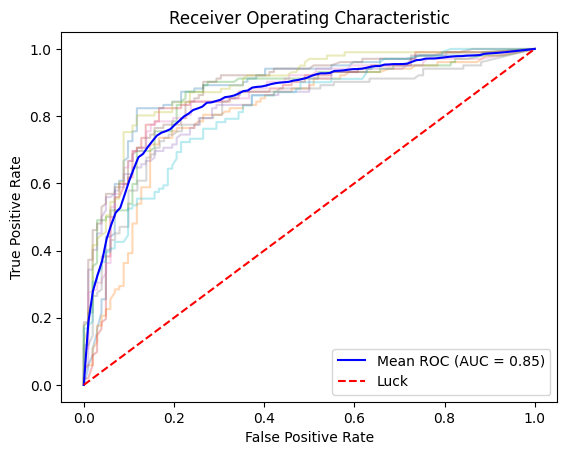

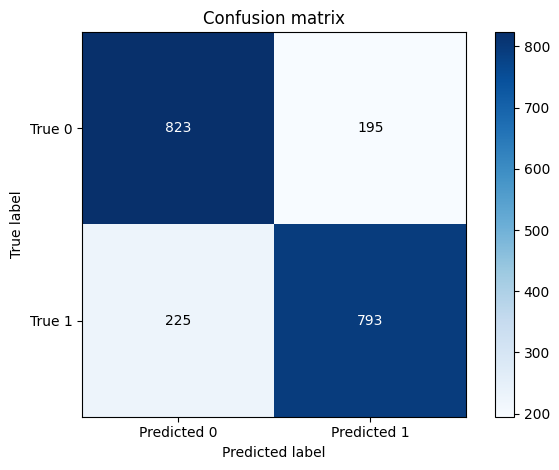

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
from scipy import interp
from numpy import mean
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import numpy as np
import pandas as pd
random_state = 2023

# Read data
data = pd.read_csv('/content/drive/MyDrive/job_data.csv')

# Parse date-time columns
date_columns = ['reported_date', 'target_finish', 'actual_finish']
for col in ['reported_date', 'target_finish', 'actual_finish']:
    data[col] = pd.to_datetime(data[col], dayfirst=True, errors='coerce')

# Drop rows with invalid datetime values
data = data.dropna(subset=date_columns)
# Create "on_time" column
data['on_time'] = (data['actual_finish'] <= data['target_finish']).astype(int)

# Create "job_duration" column
data['job_duration'] = (data['target_finish'] - data['reported_date']).dt.total_seconds() / 3600

# Handle missing data
data = data.dropna()

# Create time features
data['reported_hour'] = data['reported_date'].dt.hour
data['reported_day_of_week'] = data['reported_date'].dt.dayofweek
data['reported_month'] = data['reported_date'].dt.month
data['reported_year'] = data['reported_date'].dt.year

data['target_hour'] = data['target_finish'].dt.hour
data['target_day_of_week'] = data['target_finish'].dt.dayofweek
data['target_month'] = data['target_finish'].dt.month
data['target_year'] = data['target_finish'].dt.year

# Encode categorical features
le = LabelEncoder()
data['location_type'] = le.fit_transform(data['location_type'])
data['raised_within_workhours'] = le.fit_transform(data['raised_within_workhours'])

# Select features and target
"""
'location_type', 'raised_within_workhours' 没啥用

"""
features = data[['priority', 'location_type', 'raised_within_workhours', 'reported_hour', 'reported_day_of_week', 
                 'reported_month', 'reported_year', 'target_hour', 'target_day_of_week', 'target_month', 'target_year']]

target = data['on_time']

# Handle Class Imbalance with SMOTE
sm = SMOTE(random_state=random_state)
features_res, target_res = sm.fit_resample(features, target)

# Create and train the model

svm_model = SVC(kernel='rbf', gamma = 0.05, C=50, probability=True)        # 77.6%
# svm_model = SVC(kernel='linear', C=50)

rf_model = RandomForestClassifier(random_state=random_state)      # 78.73%

xgbc_model = XGBClassifier(eval_metric='logloss')       # 77.70%

"""
Chooce model
"""
model = rf_model

## Define K-fold cross validation
kf = StratifiedKFold(n_splits=10, random_state=random_state, shuffle=True)

tprs = []
aucs = []

mean_fpr = np.linspace(0, 1, 100)
conf_matrix = np.zeros((2, 2))  # Binary classification

fig, ax = plt.subplots()

# Perform K-fold cross validation
for i, (train_index, test_index) in enumerate(kf.split(features_res, target_res)):
    X_train, X_test = features_res.iloc[train_index], features_res.iloc[test_index]
    y_train, y_test = target_res.iloc[train_index], target_res.iloc[test_index]
    
    # Fit and predict
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # probabilities for the positive outcome

    # Compute ROC curve and AUC for this fold
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    # Update confusion matrix
    y_pred = model.predict(X_test)
    conf_matrix += confusion_matrix(y_test, y_pred)
    
    # Plot ROC curve for this fold
    ax.plot(fpr, tpr, alpha=0.3)

# Plot mean ROC curve
mean_tpr = mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
ax.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f)' % mean_auc)

# Plot luck line
ax.plot([0, 1], [0, 1], linestyle='--', color='r', label='Luck')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend(loc='lower right')

# Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(conf_matrix.shape[1]),
       yticks=np.arange(conf_matrix.shape[0]),
       xticklabels=['Predicted 0', 'Predicted 1'], 
       yticklabels=['True 0', 'True 1'],
       title='Confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Loop over data dimensions and create text annotations.
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(j, i, int(conf_matrix[i, j]),
                ha="center", va="center",
                color="white" if conf_matrix[i, j] > thresh else "black")
fig.tight_layout()

plt.show()